# Setup GDrive

In [ ]:
!pip install -q git+https://github.com/giuliano-oliveira/gdown_folder.git

import gdown
!mkdir '/content/CSV/'
!mkdir '/content/ktuner/'

gdown.download_folder('https://drive.google.com/drive/folders/1r6Qm2j4VjGXn8XThT23tP1yrF8zm-srS', quiet=True)

dir_path = '/content/CSV/'
save_path = '/content/ktuner/'

# Setup

In [ ]:
!pip install -q keras-tuner
!pip install -q tensorflow_addons
!pip install imbalanced-learn -U

In [ ]:
from google.colab import output
import time
import os
import logging
import gc
import glob
import shutil
import portpicker
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # 2 = Tensorflow INFO and WARNING messages are not printed
logging.disable(logging.WARNING)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import PReLU
from tensorflow.keras import regularizers
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ProgbarLogger
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
import keras_tuner as kt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn import svm
from sklearn.neighbors import KernelDensity
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from scipy.stats import pearsonr
import pickle

# Prepare data

In [ ]:
#@markdown [Function] Assert NaNs
def assert_nans(data):
    assert(data.isna().sum().sum()==0)

In [ ]:
#@markdown [Function] Normalize between 0 and 1
def normalize_01(data):
    return (data - data.min(0))/(data.max(0) - data.min(0))

In [ ]:
#@markdown [Function] Assert Normalization
def assert_norm(data):
    assert(data.min().min()>=0)
    assert(data.max().max()<=1)

In [ ]:
#@markdown [Function] Read CSVs
def read_CSVs(audio_path, eda_path, text_path, ann_path, ann_std_path):

    pmemo_static_audio = pd.read_csv(audio_path)
    pmemo_static_audio.iloc[:,1:] = normalize_01(pmemo_static_audio.iloc[:,1:])

    pmemo_eda_static = pd.read_csv(eda_path)
    pmemo_eda_static = pmemo_eda_static.iloc[:,1:] # Drop subject column
    pmemo_eda_static = pmemo_eda_static.fillna(0)
    pmemo_eda_static.iloc[:,1:] = normalize_01(pmemo_eda_static.iloc[:,1:])

    pmemo_text = pd.read_csv(text_path)
    pmemo_text = pmemo_text.rename(columns={"id": "musicId"})
    pmemo_text.iloc[:,1:] = normalize_01(pmemo_text.iloc[:,1:])

    pmemo_static_annotations = pd.read_csv(ann_path)
    pmemo_static_annotations_std = pd.read_csv(ann_std_path)

    assert_nans(pmemo_static_audio)
    assert_norm(pmemo_static_audio.drop('musicId',axis=1))
    assert_nans(pmemo_eda_static)
    assert_norm(pmemo_eda_static.drop('musicId',axis=1))
    assert_nans(pmemo_text)
    assert_norm(pmemo_text.drop('musicId',axis=1))
    assert_nans(pmemo_static_annotations)
    assert_norm(pmemo_static_annotations.drop('musicId',axis=1))
    assert_nans(pmemo_static_annotations_std)
    assert_norm(pmemo_static_annotations_std.drop('musicId',axis=1))

    return pmemo_static_audio, pmemo_eda_static, pmemo_text, pmemo_static_annotations, pmemo_static_annotations_std

In [ ]:
#@markdown [Function] PCA
'''This function perform PCA on the whole data'''
def perform_pca(pca_features_n, data, plot=True, desc=''):
    if plot:
        true = data
        features_before_pca = data.shape[-1]

    pca = PCA(n_components=pca_features_n)
    data = pca.fit_transform(data)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    if plot:
        predicted = pca.inverse_transform(pca.transform(true))
        rmse = mean_squared_error(true, predicted, squared=False)
        variance = np.cumsum(pca.explained_variance_ratio_*100)
        plt.ylabel('% Variance Explained')
        plt.xlabel('# of Features')
        plt.title(f'PCA of {desc}')
        plt.figtext(0.2, -0.2, f'Variance explained: {variance[-1]:.2f}%\n' +
                 f'RMSE: {rmse:.5f}\n' +
                 f'Features before PCA: {features_before_pca}\n' +
                 f'Features after PCA: {pca_features_n}',)
        plt.ylim(0,100)
        plt.plot(variance)
        plt.show()
        print()

    return data

In [ ]:
#@markdown [Function] Get valence-arousal quadrants
def get_quadrants(data):
    return np.where(
        (data['Arousal(mean)'] <= 0.5) & (data['Valence(mean)'] <= 0.5), 0,
        np.where((data['Arousal(mean)'] <= 0.5) & (data['Valence(mean)'] > 0.5), 1,
        np.where((data['Arousal(mean)'] > 0.5) & (data['Valence(mean)'] <= 0.5), 2,
        np.where((data['Arousal(mean)'] > 0.5) & (data['Valence(mean)'] > 0.5), 3,4))))

In [ ]:
#@markdown [Function] Merge audio-eda-text data and create train-val-test datasets
#@markdown based on valid indices
def merge_audio_eda_text(pmemo_static_audio, pmemo_eda_static, pmemo_text,
                         pmemo_static_annotations, pmemo_static_annotations_std):
    
    audio_id = pmemo_static_audio["musicId"]
    eda_id = pmemo_eda_static["musicId"]
    text_id = pmemo_text["musicId"]
    annotations_id = pmemo_static_annotations["musicId"]

    audio_id = set(audio_id.unique())
    eda_id = set(eda_id.unique())
    text_id = set(text_id.unique())
    annotations_id = set(annotations_id.unique())
    valid_id = audio_id.intersection(eda_id).intersection(text_id).intersection(annotations_id) # Keep IDs with measurements coming from all sources
    print(f'# of valid IDs: {len(valid_id)}')
    print()
    
    group = get_quadrants(pmemo_static_annotations)
    group_split = group[pmemo_static_annotations["musicId"].isin(valid_id)]
    id_train, id_2 = train_test_split(np.fromiter(valid_id,int), test_size=0.15, shuffle=True, stratify=group_split)
    group_split = group[pmemo_static_annotations["musicId"].isin(id_2)]
    id_val, id_test = train_test_split(id_2, test_size=0.15, stratify=group_split)

    audio_train = pmemo_static_audio.loc[pmemo_static_audio["musicId"].isin(id_train)]
    eda_train = pmemo_eda_static.loc[pmemo_eda_static["musicId"].isin(id_train)]
    text_train = pmemo_text.loc[pmemo_text["musicId"].isin(id_train)]
    static_annotations_train = pmemo_static_annotations.loc[pmemo_static_annotations["musicId"].isin(id_train)]
    static_annotations_std_train = pmemo_static_annotations_std.loc[pmemo_static_annotations_std["musicId"].isin(id_train)]

    audio_val = pmemo_static_audio.loc[pmemo_static_audio["musicId"].isin(id_val)]
    eda_val = pmemo_eda_static.loc[pmemo_eda_static["musicId"].isin(id_val)]
    text_val = pmemo_text.loc[pmemo_text["musicId"].isin(id_val)]
    static_annotations_val = pmemo_static_annotations.loc[pmemo_static_annotations["musicId"].isin(id_val)]
    static_annotations_std_val = pmemo_static_annotations_std.loc[pmemo_static_annotations_std["musicId"].isin(id_val)]

    audio_test = pmemo_static_audio.loc[pmemo_static_audio["musicId"].isin(id_test)]
    eda_test = pmemo_eda_static.loc[pmemo_eda_static["musicId"].isin(id_test)]
    text_test = pmemo_text.loc[pmemo_text["musicId"].isin(id_test)]
    static_annotations_test = pmemo_static_annotations.loc[pmemo_static_annotations["musicId"].isin(id_test)]
    static_annotations_std_test = pmemo_static_annotations_std.loc[pmemo_static_annotations_std["musicId"].isin(id_test)]


    full_train = audio_train.join(eda_train.set_index("musicId"), on="musicId", lsuffix="_0")
    full_train = full_train.join(text_train.set_index("musicId"), on="musicId", lsuffix="_0")
    full_train = full_train.join(static_annotations_train.set_index("musicId"), on="musicId", lsuffix="_0")
    full_train = full_train.join(static_annotations_std_train.set_index("musicId"), on="musicId", lsuffix="_0")

    full_val = audio_val.join(eda_val.set_index("musicId"), on="musicId", lsuffix="_0")
    full_val = full_val.join(text_val.set_index("musicId"), on="musicId", lsuffix="_0")
    full_val = full_val.join(static_annotations_val.set_index("musicId"), on="musicId", lsuffix="_0")
    full_val = full_val.join(static_annotations_std_val.set_index("musicId"), on="musicId", lsuffix="_0")

    full_test = audio_test.join(eda_test.set_index("musicId"), on="musicId", lsuffix="_0")
    full_test = full_test.join(text_test.set_index("musicId"), on="musicId", lsuffix="_0")
    full_test = full_test.join(static_annotations_test.set_index("musicId"), on="musicId", lsuffix="_0")
    full_test = full_test.join(static_annotations_std_test.set_index("musicId"), on="musicId", lsuffix="_0")

    return full_train, full_val, full_test

In [ ]:
#@markdown [Function] Oversampling based on the 4 quadrants of valence-arousal graph
def oversampling(data):

    group = get_quadrants(data)

    shrinkage = 0.05
    random_sampler = RandomOverSampler(sampling_strategy='all', shrinkage=shrinkage)

    n_neighbors = 11
    smote_sampler = ADASYN(sampling_strategy='all', n_neighbors=n_neighbors, n_jobs=-1)

    #data, group = random_sampler.fit_resample(data, group)
    data, group = smote_sampler.fit_resample(data, group)

    return data

In [ ]:
#@markdown [Function] Get data
def get_data(dir_path, audio_pca_features_n, eda_pca_features_n, oversample=True, plot_pca=False):

    (pmemo_static_audio, pmemo_eda_static, pmemo_text,
    pmemo_static_annotations, pmemo_static_annotations_std) = read_CSVs(
        audio_path = dir_path + 'static_features.csv',
        eda_path = dir_path + 'EDA_features_static.csv',
        text_path = dir_path + 'text_features.csv',
        ann_path = dir_path + 'static_annotations.csv',
        ann_std_path = dir_path + 'static_annotations_std.csv'
    )

    audio_pca = perform_pca(
        pca_features_n = audio_pca_features_n,
        data = pmemo_static_audio.iloc[:,1:],
        desc = "audio data",
        plot=plot_pca,
    )
    eda_pca = perform_pca(
        pca_features_n = eda_pca_features_n,
        data = pmemo_eda_static.iloc[:,1:],
        desc = "eda data",
        plot=plot_pca,
    )

    audio_pca = pd.DataFrame(audio_pca)
    audio_pca['musicId'] = pmemo_static_audio['musicId']
    eda_pca = pd.DataFrame(eda_pca)
    eda_pca['musicId'] = pmemo_eda_static['musicId']

    full_train, full_val, full_test = merge_audio_eda_text(
        audio_pca,
        eda_pca,
        pmemo_text,
        pmemo_static_annotations,
        pmemo_static_annotations_std
    )

    if oversample:
        plt.plot(full_train.iloc[:,-3:-2], full_train.iloc[:,-4:-3], 'o')
        plt.title('Static labels[train] before oversampling')
        plt.xlim((0,1))
        plt.ylim((0,1))
        plt.xlabel('Valence')
        plt.ylabel('Arousal')
        plt.show()

        full_train = oversampling(full_train)

        plt.plot(full_train.iloc[:,-3:-2], full_train.iloc[:,-4:-3], 'o')
        plt.title('Static labels[train] after ADASYN oversampling')
        plt.xlim((0,1))
        plt.ylim((0,1))
        plt.xlabel('Valence')
        plt.ylabel('Arousal')
        plt.show()

    audio = {}
    eda = {}
    text = {}
    ann = {}
    ann_std = {}

    audio_loc = audio_pca_features_n
    eda_loc = eda_pca_features_n

    audio['train'] = full_train.iloc[:,1:(1+audio_loc)].to_numpy()
    eda['train'] = full_train.iloc[:,(1+audio_loc):(1+audio_loc+eda_loc)].to_numpy()
    text['train'] = full_train.iloc[:,(1+audio_loc+eda_loc):(1+audio_loc+eda_loc+12)].to_numpy()
    ann['train'] = full_train.iloc[:,(1+audio_loc+eda_loc+12):(1+audio_loc+eda_loc+12+2)].to_numpy()
    ann_std['train'] = full_train.iloc[:,(1+audio_loc+eda_loc+12+2):(1+audio_loc+eda_loc+12+2+2)].to_numpy()

    audio['val'] = full_val.iloc[:,1:(1+audio_loc)].to_numpy()
    eda['val'] = full_val.iloc[:,(1+audio_loc):(1+audio_loc+eda_loc)].to_numpy()
    text['val'] = full_val.iloc[:,(1+audio_loc+eda_loc):(1+audio_loc+eda_loc+12)].to_numpy()
    ann['val'] = full_val.iloc[:,(1+audio_loc+eda_loc+12):(1+audio_loc+eda_loc+12+2)].to_numpy()
    ann_std['val'] = full_val.iloc[:,(1+audio_loc+eda_loc+12+2):(1+audio_loc+eda_loc+12+2+2)].to_numpy()

    audio['test'] = full_test.iloc[:,1:(1+audio_loc)].to_numpy()
    eda['test'] = full_test.iloc[:,(1+audio_loc):(1+audio_loc+eda_loc)].to_numpy()
    text['test'] = full_test.iloc[:,(1+audio_loc+eda_loc):(1+audio_loc+eda_loc+12)].to_numpy()
    ann['test'] = full_test.iloc[:,(1+audio_loc+eda_loc+12):(1+audio_loc+eda_loc+12+2)].to_numpy()
    ann_std['test'] = full_test.iloc[:,(1+audio_loc+eda_loc+12+2):(1+audio_loc+eda_loc+12+2+2)].to_numpy()

    assert(full_train.shape[-1] == 1+audio_loc+eda_loc+12+2+2)

    return audio, eda, text, ann, ann_std

# ICA + Rescaler of annotations

In [ ]:
#@markdown [Function] ICA
def perform_ica(data_dict, plot=True):
    
    ica = FastICA(max_iter=5000)
    ica = ica.fit(data_dict['train'])
    data_dict = {data: ica.transform(data_dict[data]) for data in data_dict}

    scaler = MinMaxScaler()
    scaler = scaler.fit(data_dict['train'])
    data_dict = {data: scaler.transform(data_dict[data]) for data in data_dict}

    if plot:
        plt.plot(data_dict['train'][:,0], data_dict['train'][:,1], 'o')
        plt.title('Static labels[train] after ICA and MinMax scaling')
        plt.show()

    return data_dict, (scaler, ica)

# NN setup

In [ ]:
#@markdown [Function] Hypermodel
'''Build hypermodel for Keras Tuner, needs 'input_dim' hyperparameter'''
def build_model(hp):

    #input = Input(shape=(512,))
    input = Input(shape=(hp.get('input_dim'),))
    x = input

    gaussian = hp.Float('gaussian_stddev', 0, 0.25)
    x = tf.keras.layers.GaussianNoise(gaussian)(x)
    
    hidden_layers = hp.Int('hidden_layers', 0, 3)
    hidden_neurons = hp.Int('hidden_neurons', 4, 64)
    hidden_activation = hp.Choice('hidden_activation',['prelu','relu','sigmoid'])

    l1_k = hp.Float('l1_k', 1e-10, 1e-4, sampling='log')
    l2_k = hp.Float('l2_k', 1e-10, 1e-4, sampling='log')
    l2_b = hp.Float('l2_b', 1e-10, 1e-4, sampling='log')
    l2_a = hp.Float('l2_a', 1e-10, 1e-4, sampling='log')

    kernel_regularizer=regularizers.l1_l2(l1=l1_k, l2=l2_k)
    bias_regularizer=regularizers.l2(l2_b)
    activity_regularizer=regularizers.l2(l2_a)

    batch_norm = hp.Fixed('batch_norm', True)
    dropout = hp.Float('dropout', 0, 0.2)

    for i in range(hidden_layers):

        x = Dense(
            hidden_neurons,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
        )(x)

        if hidden_activation == 'prelu':
            x = tf.keras.layers.PReLU()(x)
        else:
            x = Activation(hidden_activation)(x)

        x = Dropout(dropout)(x)
        
        if batch_norm:
            x = BatchNormalization()(x)


    final_activation = hp.Choice('final_activation',['prelu','relu','sigmoid'])

    x = Dense(2)(x)

    if final_activation == 'prelu':
        x = tf.keras.layers.PReLU(name='last_hidden_layer')(x)
    else:
        x = Activation(final_activation, name='last_hidden_layer')(x)

    outputs = x

    model = Model(input, outputs)

    adam_opt = Adam(amsgrad=True)
    model.compile(adam_opt, loss='mse')
    
    return model

In [ ]:
#@markdown [Function] Keras Tuner optimization
def ktuner_opt(hypermodel, train_set, val_set, objective='val_loss',
               directory='/content/ktuner_results/', name='tuner', resume=True,
               trials=100, epochs=300,
               batch_size=128, patience=15,):

    hp = kt.HyperParameters()
    hp.Fixed('input_dim',train_set[0].shape[-1])

    save_path = directory + name
    if not resume:
        if os.path.exists(save_path):
            shutil.rmtree(save_path)
    tuner = kt.RandomSearch(
        hypermodel=hypermodel,
        hyperparameters=hp,
        objective=objective,
        max_trials=trials,
        directory=directory,
        project_name=name,
        overwrite=False,
    )

    early_stopping_callback = EarlyStopping(patience=patience, restore_best_weights=True)
    #checkpoint_callback = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
    #tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress = False, show_overall_progress = True, update_per_second=1)

    tuner.search(
        x = train_set[0],\
        y = train_set[1],\
        sample_weight = train_set[2],\
        #sample_weight = {'out_0': train_set[2][:,0], 'out_1':train_set[2][:,1]},
        epochs=epochs,\
        validation_data = val_set,\
                          #(val_set[0],\
                          #val_set[1],\
                          #{'out_0': val_set[2][:,0], 'out_1':val_set[2][:,1]}),\
        batch_size=batch_size,\
        callbacks=[early_stopping_callback],\
        verbose=1,\
    )

    return tuner

In [ ]:
#@markdown [Function] Find best ensemble
def find_best_ensemble(sorted_models, data, data_name, verbose = 0):

    # Fix merge conflicts
    i = 0
    for model in sorted_models:
        model._name = f"{data_name}_model_" + str(i)
        i += 1

    input = tf.keras.Input(shape=data[0].shape[-1])

    min_loss = sorted_models[0].evaluate(data[0], data[1], sample_weight = data[2], verbose=verbose)
    best_ensemble = sorted_models[0]
    best_hidden_layers = [sorted_models[0].get_layer('last_hidden_layer')]

    for j in range(1,i):
        y = [model(input) for model in sorted_models[0:j+1]]
        output = tf.keras.layers.average(y)
        ensemble_model = tf.keras.Model(inputs=input, outputs=output)
        ensemble_model.compile("adam", loss='mse')
        loss = ensemble_model.evaluate(data[0], data[1], sample_weight = data[2], verbose=verbose)
        if loss < min_loss:
            min_loss = loss
            best_ensemble = ensemble_model
            best_hidden_layers = [model.get_layer('last_hidden_layer') for model in sorted_models[0:j+1]]

    
    return best_ensemble, min_loss, best_hidden_layers

In [ ]:
#@markdown [Function] Get sample weights
def get_sample_weights(output, output_std):
    train_weight_std = 1/(1+output_std['train'].sum(axis=1))
    val_weight_std = 1/(1+output_std['val'].sum(axis=1))

    kde = KernelDensity(kernel='gaussian', bandwidth=0.4).fit(np.concatenate((output['train'], output['val'])))
    train_weight = 1/np.exp(kde.score_samples(output['train']))
    val_weight = 1/np.exp(kde.score_samples(output['val']))
    
    train_weight = train_weight * train_weight_std
    val_weight = val_weight * val_weight_std

    return train_weight, val_weight


In [ ]:
#@markdown [Function] (Two-step) Search best model (ensemble) with Keras Tuner
def two_step_search(input, data_name, output, output_std,
                    trials, selected, epochs_1, epochs_2, batch_size,
                    patience_1, patience_2, reiterations = 0, verbose = 0):

    train_weight, val_weight = get_sample_weights(output=output, output_std=output_std)

    train_set = (input['train'], output['train'], train_weight)
    val_set = (input['val'], output['val'], val_weight)

    # First step
    tuner = ktuner_opt(
        hypermodel = build_model,
        train_set = train_set, # use std to weight annotations
        val_set = val_set, # use std to weight annotations
        name = f'random_search_{data_name}',
        resume = False,
        trials = trials,
        epochs = epochs_1,
        batch_size = batch_size,
        patience = patience_1,
    )

    sorted_models = tuner.get_best_models(trials)

    for i in range(reiterations):
        print(f'[RE-ITERATION {i+1}]')

        sorted_models = sorted(
            sorted_models,
            key = lambda m: m.evaluate(val_set[0], val_set[1], sample_weight = val_set[2], verbose=0),
        )

        early_stopping_callback = EarlyStopping(patience=patience_2, restore_best_weights=True)

        sorted_models = sorted_models[:int(selected/(2**i))]

        # Second step
        for model in sorted_models:

            print('Before retraining:')
            model.evaluate(val_set[0], val_set[1], sample_weight = val_set[2], verbose = verbose)

            model.fit(
                x = train_set[0],
                y = train_set[1],
                sample_weight = train_set[2],
                epochs = epochs_2,
                validation_data = val_set,
                batch_size = batch_size,
                callbacks = [early_stopping_callback],
                verbose=0,
            )

            print('After retraining:')
            model.evaluate(val_set[0], val_set[1], sample_weight = val_set[2], verbose = verbose)
            print()

    # Re-sort models
    sorted_models = sorted(
        sorted_models,
        key = lambda m: m.evaluate(val_set[0], val_set[1], sample_weight = val_set[2], verbose=0),
    )    

    return find_best_ensemble(
        sorted_models = sorted_models,
        data = val_set,
        data_name = data_name,
        verbose = verbose,
    ), tuner


In [ ]:
#@markdown [Function] Save tuner results
def save_results(tuner, input, output, pickle_path='', resume=False):
    if pickle_path != '' and resume and os.path.exists(pickle_path):
        results = pickle.load(open(pickle_path, 'rb'))
    else:
        results = pd.DataFrame(columns = tuner.get_best_hyperparameters()[0].values.keys())
        results.insert(len(results.columns), 'train_loss', [])
        results.insert(len(results.columns), 'val_loss', [])
        results.insert(len(results.columns), 'test_loss', [])

    for trial in tuner.oracle.trials.values():
        row = trial.hyperparameters.values.copy()
        model = tuner.load_model(trial)
        row['train_loss'] = model.evaluate(input['train'], output['train'], verbose=0)
        row['val_loss'] = model.evaluate(input['val'], output['val'], verbose=0)
        row['test_loss'] = model.evaluate(input['test'], output['test'], verbose=0)
        results = results.append(row, ignore_index=True)
    results = results.convert_dtypes()

    if pickle_path != '':
        results.to_pickle(pickle_path)
    return results

In [ ]:
#@markdown [Function] Save best models
def save_best_models(n, path):
    i = 0
    for model in tuner.get_best_models(n):
        model.save(path+f'model_{i}')
        i += 1

In [ ]:
#@markdown [Function] Errorbars plot
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
    return df

def plot_errorbars(df, by:str):
    #df = remove_outliers(df, 'val_loss')
    gb = df[[by,'train_loss','val_loss','test_loss']].groupby(by)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,3.5))
    fig.suptitle(f'Loss over [{by}]', fontsize=16)
    axes = axes.ravel()

    if by[0] == 'l': axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    if len(df[by].unique()) > 5:
        gb.mean().plot(title='Mean', ax=axes[0])
    else:
        gb.mean().plot.bar(yerr=gb.std(), capsize=3, title='Mean', ax=axes[0])

    if by[0] == 'l': axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    if len(df[by].unique()) > 5:
        gb.min().plot(title='Min', ax=axes[1])
    else:
        gb.min().plot.bar(capsize=3, title='Min', ax=axes[1])

    plt.show()

In [ ]:
#@markdown [Function] Scatter plot from model predictions

def scatter_from_model(predicted, true):
    mse_arousal = mean_squared_error(true[:,0], predicted[:,0], squared=True)
    mse_valence = mean_squared_error(true[:,1], predicted[:,1], squared=True)
    rmse_arousal = mean_squared_error(true[:,0], predicted[:,0], squared=False)
    rmse_valence = mean_squared_error(true[:,1], predicted[:,1], squared=False)
    pearsonr_arousal = pearsonr(true[:,0], predicted[:,0])[0]
    pearsonr_valence = pearsonr(true[:,1], predicted[:,1])[0]

    plt.scatter(true[:,0],true[:,1], c='blue', label='True')
    plt.scatter(predicted[:,0],predicted[:,1], c='red', label='Predicted')
    plt.xlim((0,1))
    plt.xlabel('Arousal')
    plt.ylim((0,1))
    plt.ylabel('Valence')
    plt.legend(['True','Predicted'])
    plt.show()
    print(f'MSE arousal: {mse_arousal}')
    print(f'MSE valence: {mse_valence}')
    print(f'RMSE arousal: {rmse_arousal}')
    print(f'RMSE valence: {rmse_valence}')
    print(f'Pearson r arousal: {pearsonr_arousal}')
    print(f'Pearson r valence: {pearsonr_valence}')

# Example run

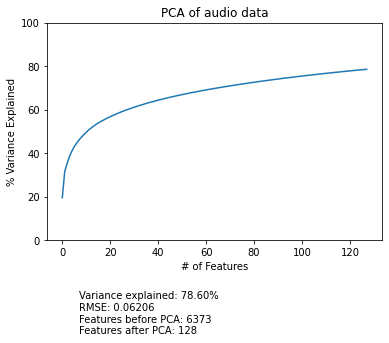

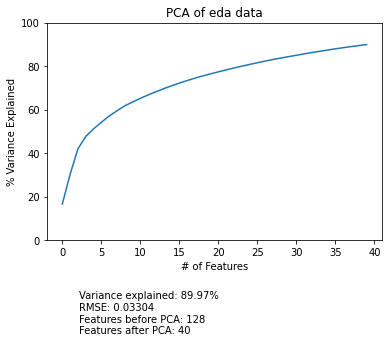


# of valid IDs: 482



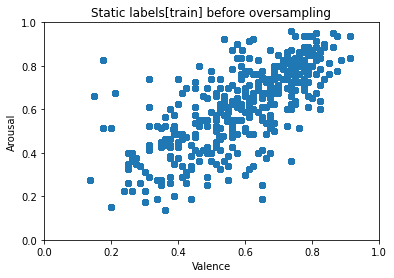

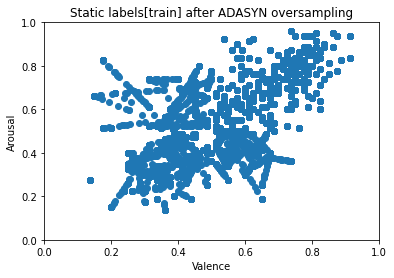

In [ ]:
audio_pca_features_n = 128
eda_pca_features_n = 40

audio, eda, text, ann, ann_std = get_data(
    dir_path = dir_path,
    audio_pca_features_n = audio_pca_features_n,
    eda_pca_features_n = eda_pca_features_n,
    plot_pca = True,
)

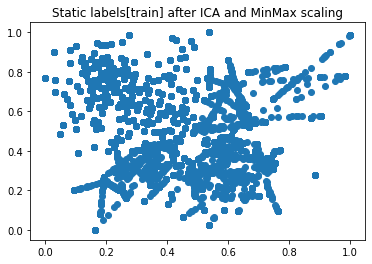

In [ ]:
ann_ica, (scaler_ann, ica_ann) = perform_ica(ann)

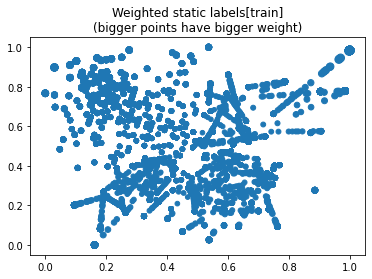

In [ ]:
train_weight, val_weight = get_sample_weights(output=ann_ica, output_std=ann_std)

plt.scatter(ann_ica['train'][:,0], ann_ica['train'][:,1], s=train_weight*20)
plt.title('Weighted static labels[train]\n(bigger points have bigger weight)')
plt.show()

In [ ]:
TRIALS = 10
SELECTED = 3
EPOCHS_1 = 2000
EPOCHS_2 = 5000
BATCH_SIZE = 64
PATIENCE_1 = 25
PATIENCE_2 = 100
REITERATIONS = 1
VERBOSE = 1
best_ensemble = {}
min_loss = {}
best_hidden_layers = {}

In [ ]:
full_data = {
    'train':np.concatenate((audio['train'],eda['train'],text['train']), axis=1),
    'val':np.concatenate((audio['val'],eda['val'],text['val']), axis=1),
    'test':np.concatenate((audio['test'],eda['test'],text['test']), axis=1),
}

cycle_data = [(full_data, 'audio_eda_text')]

for data, name in cycle_data:

    tf.keras.backend.clear_session()
    gc.collect()

    (best_ensemble[name], min_loss[name], best_hidden_layers[name]), tuner = two_step_search(
        input = data,
        data_name = name,
        output = ann_ica,
        output_std = ann_std,
        trials = TRIALS,
        selected = SELECTED,
        epochs_1 = EPOCHS_1,
        epochs_2 = EPOCHS_2,
        batch_size = BATCH_SIZE,
        patience_1 = PATIENCE_1,
        patience_2 = PATIENCE_2,
        reiterations = REITERATIONS,
        verbose = VERBOSE,
    )

Trial 10 Complete [00h 00m 57s]
val_loss: 0.03520732372999191

Best val_loss So Far: 0.033207911998033524
Total elapsed time: 00h 06m 57s
[RE-ITERATION 1]
Before retraining:
20/20 [==============================] - 0s 1ms/step - loss: 0.0332
After retraining:
20/20 [==============================] - 0s 1ms/step - loss: 0.0329

Before retraining:
20/20 [==============================] - 0s 1ms/step - loss: 0.0334
After retraining:
20/20 [==============================] - 0s 2ms/step - loss: 0.0322

Before retraining:
20/20 [==============================] - 0s 1ms/step - loss: 0.0351
After retraining:
20/20 [==============================] - 0s 2ms/step - loss: 0.0333

20/20 [==============================] - 0s 2ms/step - loss: 0.0348


[AUDIO_EDA_TEXT TRAIN DATA]


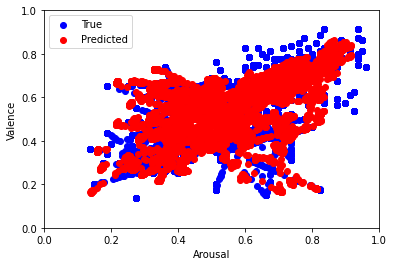

MSE arousal: 0.0020993869666891263
MSE valence: 0.0021407046654791173
RMSE arousal: 0.04581906771955455
RMSE valence: 0.04626774973433566
Pearson r arousal: 0.9688808147517203
Pearson r valence: 0.9593224991503565


[AUDIO_EDA_TEXT VAL DATA]


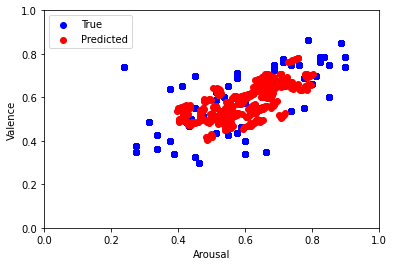

MSE arousal: 0.017980286909605212
MSE valence: 0.014841237400865539
RMSE arousal: 0.13409059217411642
RMSE valence: 0.12182461738444139
Pearson r arousal: 0.6384645416984992
Pearson r valence: 0.6191129808449674


[AUDIO_EDA_TEXT TEST DATA]


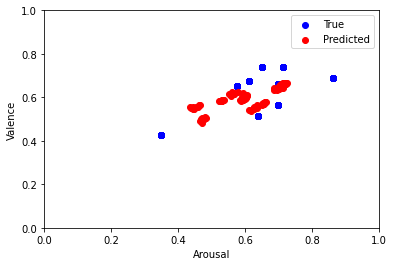

MSE arousal: 0.014415941863590688
MSE valence: 0.010823785521976213
RMSE arousal: 0.12006640605760917
RMSE valence: 0.10403742366079724
Pearson r arousal: 0.4478299252647661
Pearson r valence: 0.10025413447107083




In [ ]:
for data, name in [(full_data, 'audio_eda_text')]:
    for data_type in ['train','val','test']:
        print(f'[{name.upper()} {data_type.upper()} DATA]')

        predicted = best_ensemble[name].predict(data[data_type])

        predicted = ica_ann.inverse_transform(scaler_ann.inverse_transform(predicted))

        scatter_from_model(
            predicted = predicted,
            true = ann[data_type],
        )

        for i in range(2): print()

In [ ]:
results = save_results(tuner=tuner, input=full_data, output=ann_ica, pickle_path='/content/ktuner/results.pkl', resume=False)
#save_best_models(TRIALS, '/content/ktuner/saved_models/')
#!cp -r '/content/ktuner' '/content/gdrive/MyDrive/Colab Notebooks/INMCA_2021/ktuner_bkp'

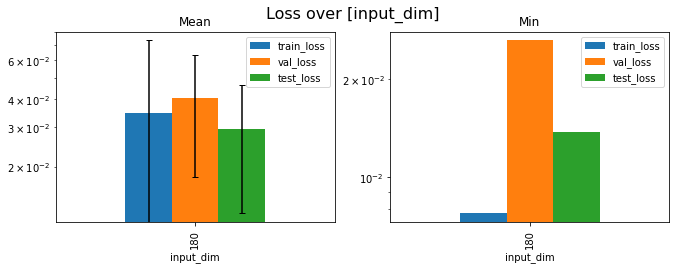

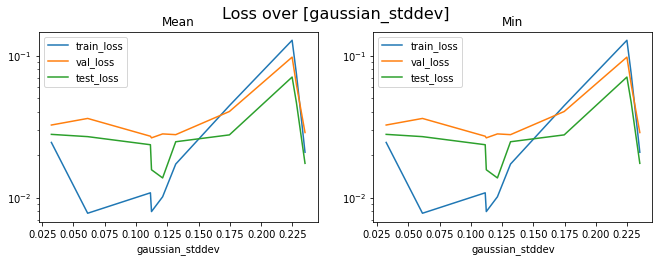

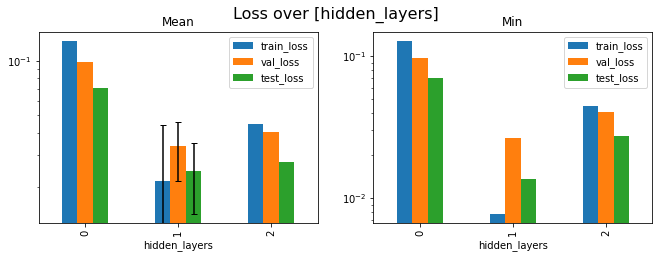

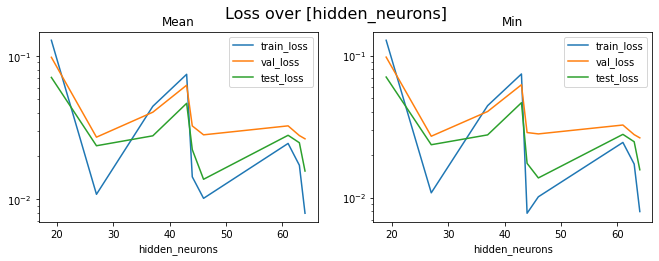

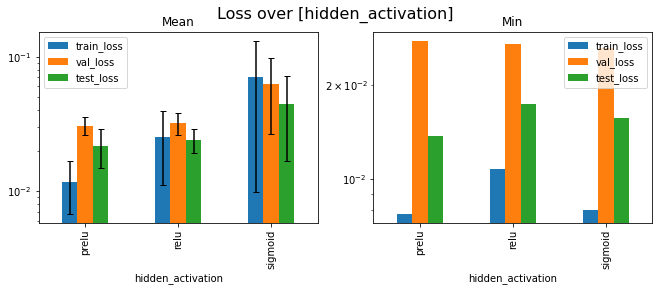

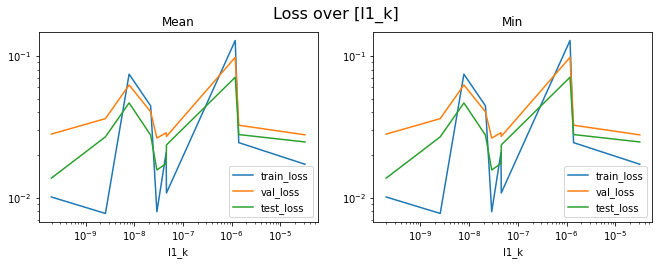

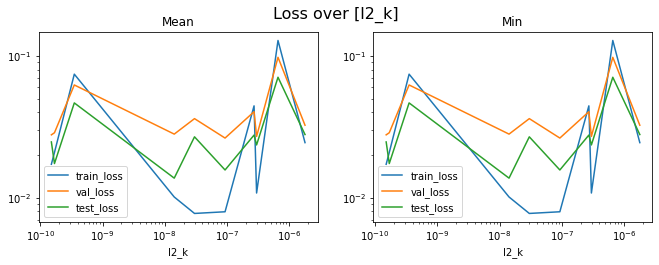

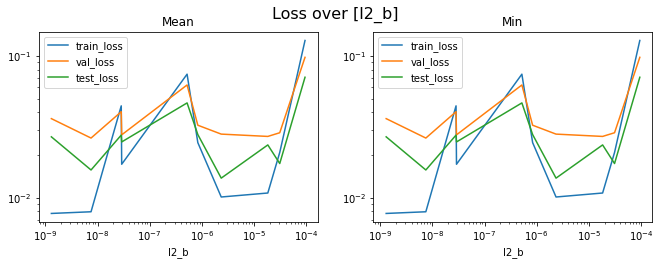

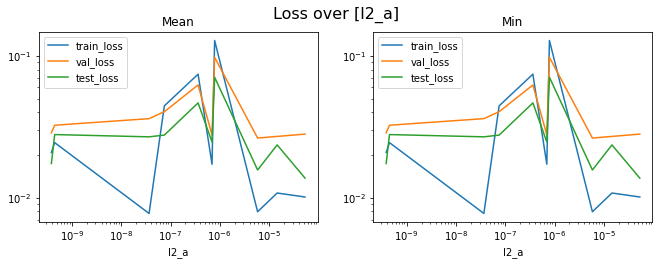

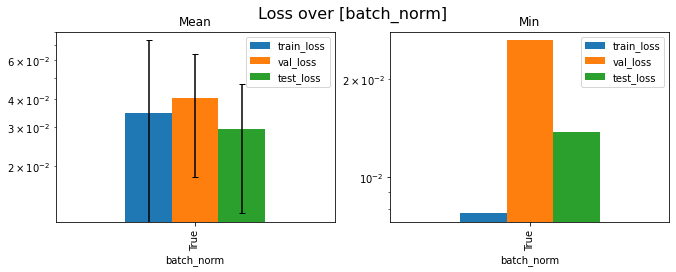

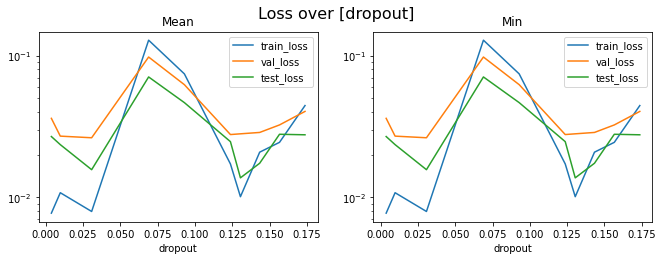

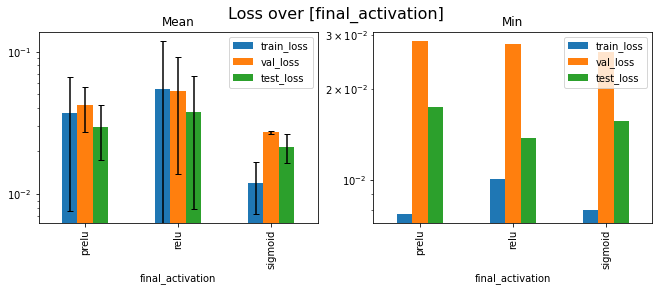

In [ ]:
for column in results.columns:
    if not (column in ['train_loss','val_loss','test_loss']):
        plot_errorbars(results, column)

# Run experiment

In [ ]:
#@markdown [Function] Run experiment
def run_experiment(times):

    rmse_r_df = pd.DataFrame(columns = ['rmse_arousal', 'r_arousal', 'rmse_valence', 'r_valence', 'data_type'])

    for i in range(times):
        audio_pca_features_n = 128
        eda_pca_features_n = 40

        audio, eda, text, ann, ann_std = get_data(
            dir_path = dir_path,
            audio_pca_features_n = audio_pca_features_n,
            eda_pca_features_n = eda_pca_features_n,
            plot_pca = False,
        )

        ann_ica, (scaler_ann, ica_ann) = perform_ica(ann, plot=False)

        TRIALS = 50
        SELECTED = 10
        EPOCHS_1 = 2000
        EPOCHS_2 = 5000
        BATCH_SIZE = 64
        PATIENCE_1 = 20
        PATIENCE_2 = 80
        REITERATIONS = 1
        VERBOSE = 1
        best_ensemble = {}
        min_loss = {}
        best_hidden_layers = {}

        full_data = {
            'train':np.concatenate((audio['train'],eda['train'],text['train']), axis=1),
            'val':np.concatenate((audio['val'],eda['val'],text['val']), axis=1),
            'test':np.concatenate((audio['test'],eda['test'],text['test']), axis=1),
        }

        cycle_data = [(full_data, 'audio_eda_text')]

        for data, name in cycle_data:

            tf.keras.backend.clear_session()
            gc.collect()

            (best_ensemble[name], min_loss[name], best_hidden_layers[name]), tuner = two_step_search(
                input = data,
                data_name = name,
                output = ann_ica,
                output_std = ann_std,
                trials = TRIALS,
                selected = SELECTED,
                epochs_1 = EPOCHS_1,
                epochs_2 = EPOCHS_2,
                batch_size = BATCH_SIZE,
                patience_1 = PATIENCE_1,
                patience_2 = PATIENCE_2,
                reiterations = REITERATIONS,
                verbose = VERBOSE,
            )

            for data_type in ['train','val','test']:
                predicted = best_ensemble[name].predict(data[data_type])
                predicted = ica_ann.inverse_transform(scaler_ann.inverse_transform(predicted))
                true = ann[data_type]

                rmse_r = {}
                rmse_r['rmse_arousal'] = mean_squared_error(true[:,0], predicted[:,0], squared=False)
                rmse_r['rmse_valence'] = mean_squared_error(true[:,1], predicted[:,1], squared=False)
                rmse_r['r_arousal'] = pearsonr(true[:,0], predicted[:,0])[0]
                rmse_r['r_valence'] = pearsonr(true[:,1], predicted[:,1])[0]
                rmse_r['data_type'] = data_type

                rmse_r_df = rmse_r_df.append(rmse_r, ignore_index=True)

        results = save_results(tuner=tuner, input=full_data, output=ann_ica, pickle_path=f'/content/ktuner/run_experiment_{times}_times.pkl', resume=True)

    output.clear()

    for column in results.columns:
        if not (column in ['train_loss','val_loss','test_loss']):
            plot_errorbars(results, column)
    
    return results, rmse_r_df

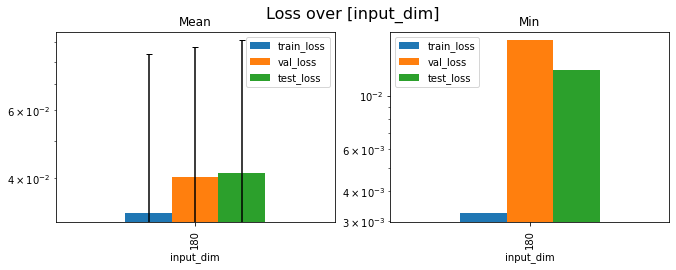

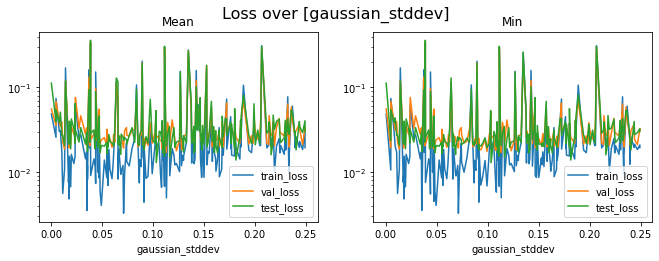

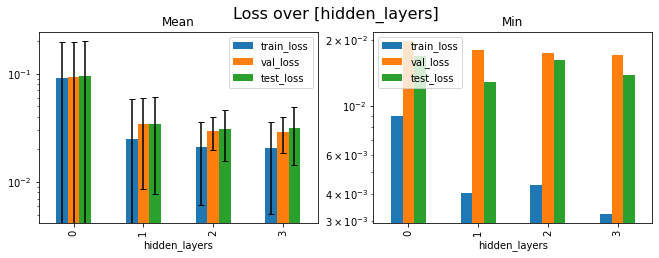

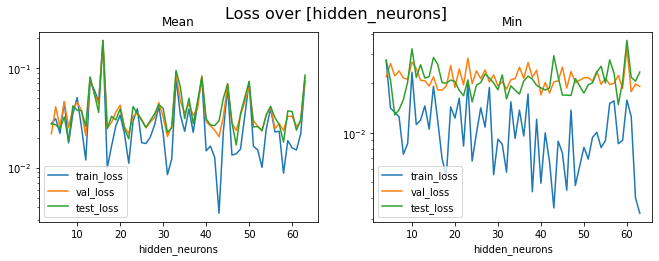

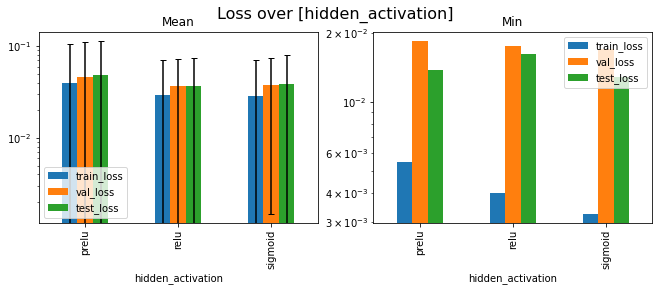

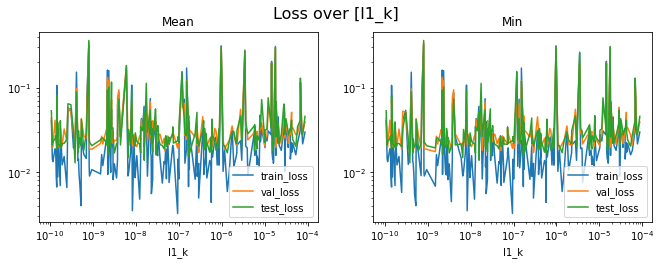

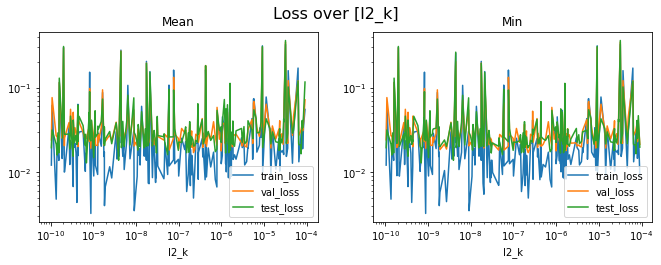

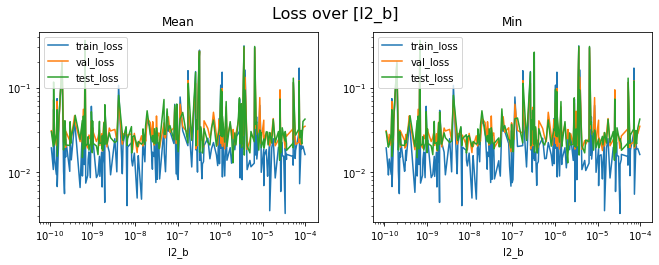

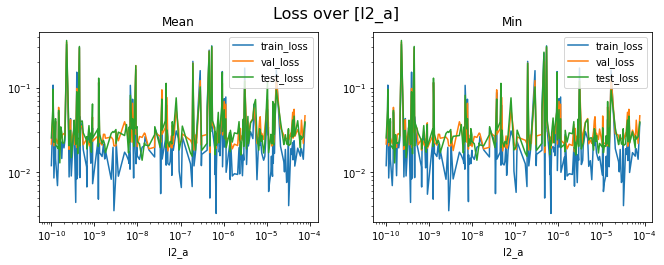

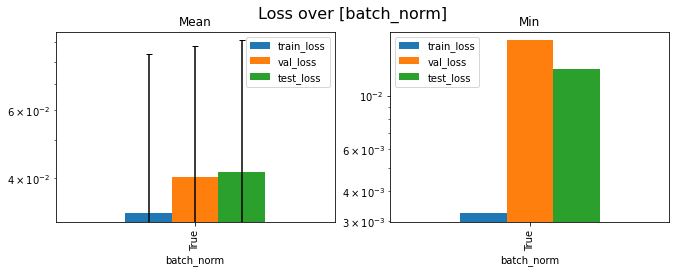

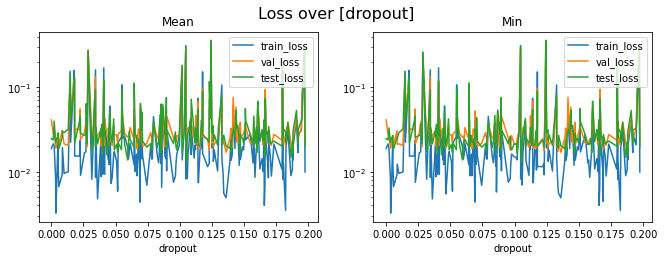

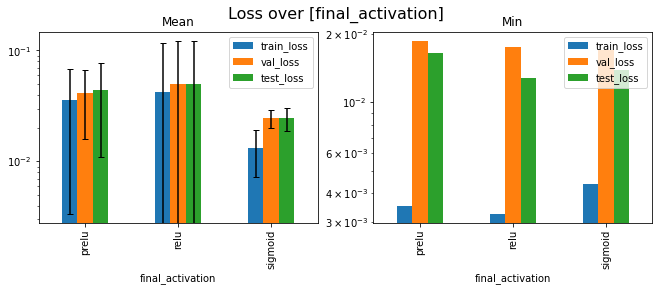

In [ ]:
results, rmse_df = run_experiment(5)

RMSE mean
           rmse_arousal  rmse_valence
data_type                            
train          0.065115      0.059066
val            0.124412      0.122757
test           0.120897      0.122119



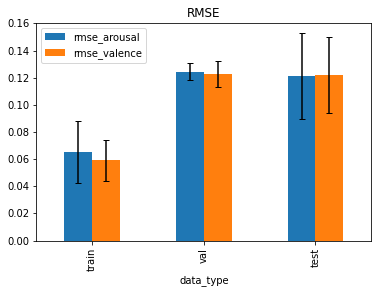


Pearson r mean
           r_arousal  r_valence
data_type                      
train       0.938232   0.930360
val         0.751302   0.666185
test        0.745949   0.542578



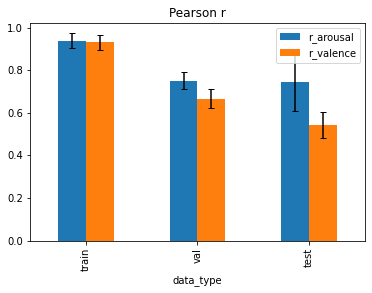

In [ ]:
gb_rmse = rmse_df.groupby('data_type')['rmse_arousal','rmse_valence']
gb_r = rmse_df.groupby('data_type')['r_arousal','r_valence']
order = ['train', 'val', 'test']
print('RMSE mean')
print(gb_rmse.mean().loc[order])
print()
gb_rmse.mean().loc[order].plot.bar(yerr=gb_rmse.std(), capsize=3, title='RMSE')
plt.show()
print()
print('Pearson r mean')
print(gb_r.mean().loc[order])
print()
gb_r.mean().loc[order].plot.bar(yerr=gb_r.std(), capsize=3, title='Pearson r')
plt.show()